# Lesson 02

## 1. Прочитайте базу "Потребление Энергии" и сделайте модель для сезонных изменений по data_exp_1 с глубиной прогноза h=1 и h=10 по образцу из примера для обработки ряда "цена Нефти".

In [1]:
import pandas as pd

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
url_pjme = 'https://d2xzmw6cctk25h.cloudfront.net/asset/1613504/attachment/dae2ac5cd7e3ac92bd6413613dc8244c.csv'

In [3]:
df_pjme = pd.read_csv(url_pjme, index_col=[0], parse_dates=[0])

In [4]:
df_pjme.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


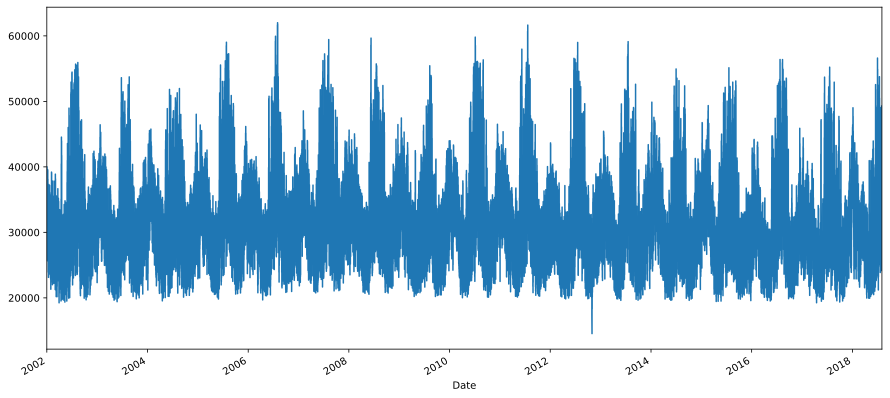

In [5]:
df_pjme.PJME_MW.plot(figsize=(15,7));

In [6]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [7]:
data_exp_1 = exponential_smoothing(df_pjme.PJME_MW  , 0.05)

In [8]:
df = pd.DataFrame(data_exp_1, columns=['exponential_smoothing_0.05'], index=df_pjme.index)

In [9]:
for i in range(1,4):
    df[f't{i}']=0
    df.iloc[i:,i]=df.iloc[:-i,0].values

In [10]:
def split_data_b(data, split_date):
    return data.loc[data.index <= split_date].copy(), \
           data.loc[data.index >  split_date].copy()

In [11]:
train_b, test_b = split_data_b(df, '01-01-2017')

In [12]:
model = GradientBoostingRegressor(max_depth=15, random_state=0, n_estimators=100)

In [13]:
def predict_model(model, h, train_b, test_b):

    X_train_b = train_b.iloc[:-h,:]
    y_train_b = train_b[df.columns[0]].values[h:]
    X_test_b = test_b.iloc[:-h,:]
    y_test_b = test_b[df.columns[0]].values[h:]

    model.fit(X_train_b, y_train_b)
    X_test_pred = model.predict(X_test_b)
    return X_test_pred, y_test_b

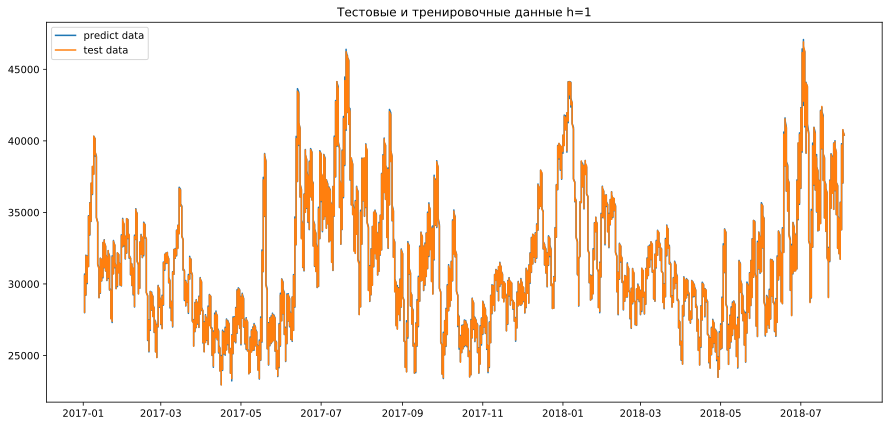

In [14]:
h=1
X_test_pred_h1, y_test_b_h1 = predict_model(model, h, train_b, test_b)

plt.figure(figsize=(15, 7))

plt.plot(test_b.index[h:],X_test_pred_h1, label='predict data')
plt.plot(test_b.index[h:],y_test_b_h1, label='test data')

plt.title(f'Тестовые и тренировочные данные h={h}')
plt.legend()
plt.show()

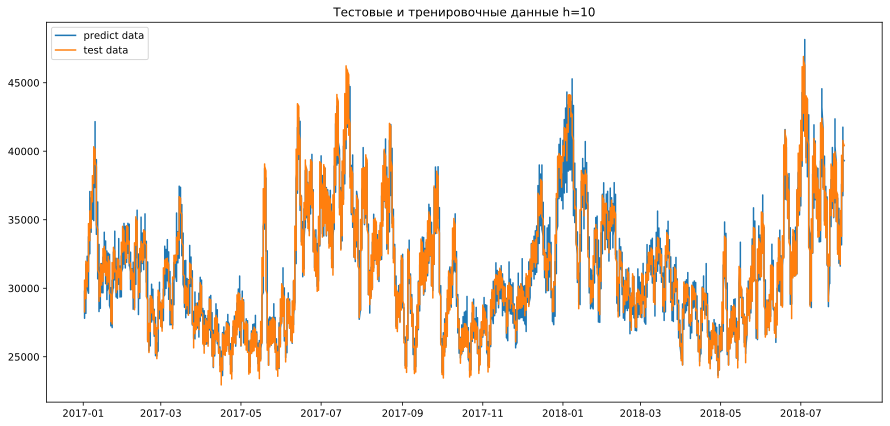

In [15]:
h=10
X_test_pred_h10, y_test_b_h10 = predict_model(model, h, train_b, test_b)

plt.figure(figsize=(15, 7))

plt.plot(test_b.index[h:],X_test_pred_h10, label='predict data')
plt.plot(test_b.index[h:],y_test_b_h10, label='test data')

plt.title(f'Тестовые и тренировочные данные h={h}')
plt.legend()
plt.show()

## 2. Оцените ошибку модели из п.1.

In [16]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [17]:
print(f'Error h=1: {mean_absolute_percentage_error(y_test_b_h1, X_test_pred_h1):.02f}%')
print(f'Error h=10: {mean_absolute_percentage_error(y_test_b_h10, X_test_pred_h10):.02f}%')

Error h=1: 0.11%
Error h=10: 3.29%


## 3. Сделайте вывод о том, как изменилась ошибка модели по значениям h.

Чем выше выше глубина прогноза, тем больше растет ошибка. Можно уменьшить ошибку увеличив глубину авторегрессии(увеличив предисторию).

In [18]:
for i in range(4,11):
    df[f't{i}']=0
    df.iloc[i:,i]=df.iloc[:-i,0].values

In [19]:
train_b, test_b = split_data_b(df, '01-01-2017')
h=10
X_test_pred_h10, y_test_b_h10 = predict_model(model, h, train_b, test_b)

print(f'Error h=10, p=10: {mean_absolute_percentage_error(y_test_b_h10, X_test_pred_h10):.02f}%')

Error h=10, p=10: 2.57%


## 4. Попробуйте предположить характер ряда (стационарный или нет, с трендом, с сезоном, с циклом) для рядов из списка и аргументируйте свой ответ (одна строка):

а) Изменение температуры за окном.  
 Стационарный, если  брать годовые интервалы, а если брать меньшие интервалы, то не стационарный.  
 С трендом - есть тенденция к увеличению температуры из-за глобального потепления.  
 С сезоном/С циклом - температура зависит от времени года, от циклов солнечной активности.  
 
б) Количество денег, которые тратят покупатели в интернет магазине.  
    Не стационарный - сильное влияние сезонности (распродажи)  
    С трендом - ежегодное увеличение объемов продаж  
    С сезоном/С циклом - сезонные распродажи  

в) Вес растущего котенка.
    Не стационарный - вес меняется  
    С трендом - до определенного возраста, когда котенок растет. У взрослой кошки - вес не меняется  
    Без сезонов/без циклов - вес меняется стабильно.  

г) Прирост объема деревьев в лесу от времени  
    Стационарный - среднее количество деревье практически не изменяется  
    С трендом - количество деревьев склонно к изменение, под действием внешних факторов  
    С сезоном/С циклом - есть зависимость от времени года и циклов солнечной активности  